# setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pickle
import random
from typing import Sequence, Tuple
from tempfile import mkdtemp

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier, Pool


pd.set_option('display.max_rows', 100)

In [3]:
from src.io import csv_loader_factory, PickleLoader
from src.preprocessing import TextCleaner
from src.embeddings import W2VEmbedder
from src.eval.metrics import compute_metrics

# load raw 

In [4]:
loader = csv_loader_factory('poleval')
data = loader.load()

INFO:2022-01-09 22:15:28:io:loading from csv: ./data/poleval19.csv
INFO:2022-01-09 22:15:28:io:loaded 11041 rows


# base eda

In [5]:
data.shape

(11041, 3)

In [6]:
data.head()

,dataset,text_raw,tag
0,train,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,train,@anonymized_account @anonymized_account Brawo ...,0
2,train,"@anonymized_account @anonymized_account Super,...",0
3,train,@anonymized_account @anonymized_account Musi. ...,0
4,train,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


In [7]:
data.groupby('dataset').agg(
    size=('text_raw', 'size'),
    target=('tag', 'mean')
)

,size,target
dataset,,
test,1000,0.134000
train,10041,0.084753


# catboost on raw data

## prep data

In [8]:
train_df = data.loc[data['dataset']=='train', ['text_raw']]
train_label = data.loc[data['dataset']=='train', 'tag']
test_df = data.loc[data['dataset']=='test', ['text_raw']]
test_label = data.loc[data['dataset']=='test', 'tag']

train_pool = Pool(train_df, label=train_label, text_features=['text_raw'])
test_pool = Pool(test_df, label=test_label, text_features=['text_raw'])

## train model

In [9]:
params = {
    'eval_metric': 'AUC',
    'text_features': ['text_raw'],
    'metric_period': 10,
    'verbose': 10,
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_df, y=train_label, eval_set=(test_df, test_label))

Learning rate set to 0.056021
0:	test: 0.5000000	best: 0.5000000 (0)	total: 261ms	remaining: 4m 20s
10:	test: 0.7002602	best: 0.7002602 (10)	total: 1.09s	remaining: 1m 38s
20:	test: 0.7979818	best: 0.7979818 (20)	total: 1.95s	remaining: 1m 30s
30:	test: 0.7850083	best: 0.7979818 (20)	total: 2.8s	remaining: 1m 27s
40:	test: 0.7908078	best: 0.7979818 (20)	total: 3.59s	remaining: 1m 23s
50:	test: 0.7936386	best: 0.7979818 (20)	total: 4.42s	remaining: 1m 22s
60:	test: 0.7932164	best: 0.7979818 (20)	total: 5.21s	remaining: 1m 20s
70:	test: 0.7949226	best: 0.7979818 (20)	total: 5.98s	remaining: 1m 18s
80:	test: 0.7967538	best: 0.7979818 (20)	total: 6.77s	remaining: 1m 16s
90:	test: 0.7985979	best: 0.7985979 (90)	total: 7.6s	remaining: 1m 15s
100:	test: 0.7976371	best: 0.7985979 (90)	total: 8.44s	remaining: 1m 15s
110:	test: 0.8004636	best: 0.8004636 (110)	total: 9.43s	remaining: 1m 15s
120:	test: 0.8002740	best: 0.8004636 (110)	total: 10.1s	remaining: 1m 13s
130:	test: 0.7999897	best: 0.8004

## summ

,train,test
AUC,0.560178,0.518635
Accuracy,0.834761,0.802803
F1,0.023543,0.075117
Precision,0.023585,0.101266
Recall,0.023502,0.059701


|mean pred |0.158266|0.158236|


<AxesSubplot:ylabel='Frequency'>

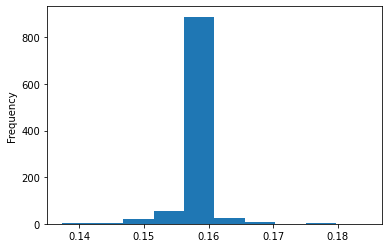

In [134]:
proba_train = cb.predict_proba(train_df)[:, 1]
proba_test = cb.predict_proba(test_df)[:, 1]

display(compute_metrics((train_label, proba_train), (test_label, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

# catboost on cleaned

## prep data

In [135]:
cleaner = TextCleaner()
cleaner.get_params()

{'clean_email': True,
 'clean_emoji': True,
 'clean_hashtag': True,
 'clean_non_alpha': True,
 'clean_non_letter': True,
 'clean_url': True,
 'clean_user_ref': True,
 'drop_repeated': True,
 'latinize': True,
 'to_lower': True}

In [136]:
train_clean = cleaner.fit_transform(train_df['text_raw'])
train_clean = pd.DataFrame(train_clean, columns=['text_clean'])


test_clean = cleaner.transform(test_df['text_raw'])
test_clean = pd.DataFrame(test_clean, columns=['text_clean'])


train_pool_clean = Pool(train_clean, label=train_label, text_features=['text_clean'])
test_pool_clean = Pool(test_clean, label=test_label, text_features=['text_clean'])

## train model

In [146]:
params = {
    'eval_metric': 'AUC',
    'text_features': ['text_clean'],
    'verbose': 10,
    'early_stopping_rounds': 30
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_clean, y=train_label, eval_set=(test_clean, test_label))

Learning rate set to 0.056019
0:	test: 0.4994220	best: 0.4994220 (0)	total: 59.4ms	remaining: 59.3s
10:	test: 0.5094427	best: 0.5094427 (10)	total: 791ms	remaining: 1m 11s
20:	test: 0.4975153	best: 0.5094427 (10)	total: 1.75s	remaining: 1m 21s
30:	test: 0.4803080	best: 0.5094427 (10)	total: 2.56s	remaining: 1m 20s
40:	test: 0.4903977	best: 0.5094427 (10)	total: 3.42s	remaining: 1m 20s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.509442671
bestIteration = 10

Shrink model to first 11 iterations.


## summ

,train,test
AUC,0.526524,0.509443
Accuracy,0.858765,0.823824
F1,0.041892,0.073684
Precision,0.049285,0.125000
Recall,0.036428,0.052239


|mean pred |0.24648|0.246439|


<AxesSubplot:ylabel='Frequency'>

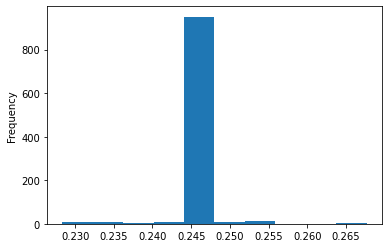

In [147]:
proba_train = cb.predict_proba(train_clean)[:, 1]
proba_test = cb.predict_proba(test_clean)[:, 1]

display(compute_metrics((train_label, proba_train), (test_label, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

<AxesSubplot:ylabel='Frequency'>

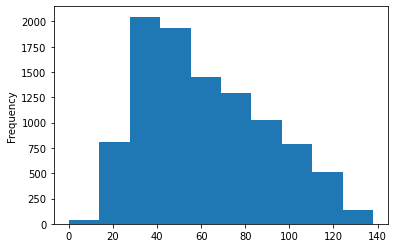

In [250]:
pd.Series(map(len, train_clean['text_clean'])).plot.hist()

In [249]:
pd.Series(map(len, train_clean['text_clean'])).value_counts(dropna=False).sort_index()

0      14
2       2
7       1
9       1
10      2
       ..
134     4
135     5
136     7
137     1
138     1
Length: 133, dtype: int64

<AxesSubplot:ylabel='Frequency'>

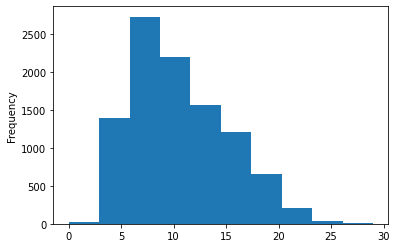

In [254]:
pd.Series(map(len, train_tokens)).plot.hist()

In [253]:
pd.Series(map(len, train_tokens)).value_counts().sort_index()

0       14
1        2
2        2
3       37
4      357
5     1004
6      974
7      911
8      848
9      761
10     767
11     676
12     549
13     540
14     477
15     463
16     408
17     345
18     280
19     209
20     165
21     110
22      62
23      34
24      22
25      11
26       3
27       4
28       4
29       1
dtype: int64

# w2v on cleaned

## prep data

In [138]:
# train
train_tokens = pd.Series(map(lambda text: text.split(), train_clean['text_clean']))
train_tokens.index = train_clean.index

train_tokens = train_tokens[(pd.Series(map(len, train_tokens))>0).values]
train_label_tok = train_label[train_tokens.index]


# test
test_tokens = pd.Series(map(lambda text: text.split(), test_clean['text_clean']))
test_tokens.index = test_clean.index

test_tokens = test_tokens[(pd.Series(map(len, test_tokens))>0).values]
test_label_tok = test_label[test_tokens.index]

In [139]:
emb = W2VEmbedder()
emb.get_params()

{'alpha': 0.025,
 'cbow_mean': 1,
 'epochs': 5,
 'hs': 0,
 'max_final_vocab': None,
 'min_alpha': 0.0001,
 'min_count': 5,
 'model_name': 'w2v',
 'negative': 5,
 'ns_exponent': 0.75,
 'sample': 0.001,
 'sg': 0,
 'vector_size': 20,
 'window': 5,
 'workers': 8}

In [18]:
emb.fit(train_tokens)

INFO:2022-01-07 20:20:36:gensim.models.word2vec:collecting all words and their counts
INFO:2022-01-07 20:20:36:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:2022-01-07 20:20:37:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 104799 words, keeping 21734 word types
INFO:2022-01-07 20:20:37:gensim.models.word2vec:collected 21764 word types from a corpus of 105046 raw words and 10026 sentences
INFO:2022-01-07 20:20:37:gensim.models.word2vec:Creating a fresh vocabulary
INFO:2022-01-07 20:20:37:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2518 unique words (11.56956441830546%% of original 21764, drops 19246)', 'datetime': '2022-01-07T20:20:37.039782', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO:2022-01-07 20:20:37:gensim.utils:Word2Vec lifecycle event {'msg': 'e

INFO:2022-01-07 20:20:37:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec(vocab=2518, vector_size=20, alpha=0.025)', 'datetime': '2022-01-07T20:20:37.320856', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


W2VEmbedder()

In [20]:
train_w2v = emb.transform(train_tokens)
test_w2v = emb.transform(test_tokens)

## train model

In [153]:
params = {
    'eval_metric': 'AUC',
    'early_stopping_rounds': 200,
    'verbose': 10,
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_w2v, y=train_label_tok, eval_set=(test_w2v, test_label_tok))

Learning rate set to 0.056
0:	test: 0.4827582	best: 0.4827582 (0)	total: 7.08ms	remaining: 7.07s
10:	test: 0.5062203	best: 0.5152877 (3)	total: 69.7ms	remaining: 6.27s
20:	test: 0.4705159	best: 0.5152877 (3)	total: 131ms	remaining: 6.12s
30:	test: 0.4825166	best: 0.5152877 (3)	total: 196ms	remaining: 6.12s
40:	test: 0.4972694	best: 0.5152877 (3)	total: 262ms	remaining: 6.13s
50:	test: 0.4954620	best: 0.5152877 (3)	total: 324ms	remaining: 6.03s
60:	test: 0.4990424	best: 0.5152877 (3)	total: 386ms	remaining: 5.95s
70:	test: 0.4976922	best: 0.5152877 (3)	total: 450ms	remaining: 5.89s
80:	test: 0.4807264	best: 0.5152877 (3)	total: 512ms	remaining: 5.81s
90:	test: 0.4820119	best: 0.5152877 (3)	total: 574ms	remaining: 5.74s
100:	test: 0.4800017	best: 0.5152877 (3)	total: 636ms	remaining: 5.66s
110:	test: 0.4726167	best: 0.5152877 (3)	total: 700ms	remaining: 5.6s
120:	test: 0.4690277	best: 0.5152877 (3)	total: 761ms	remaining: 5.53s
130:	test: 0.4777414	best: 0.5152877 (3)	total: 825ms	remain

## summ

,train,test
AUC,0.551923,0.515249
Accuracy,0.859565,0.819820
F1,0.063830,0.072165
Precision,0.073282,0.116667
Recall,0.056537,0.052239


|mean pred |0.379661|0.379834|


<AxesSubplot:ylabel='Frequency'>

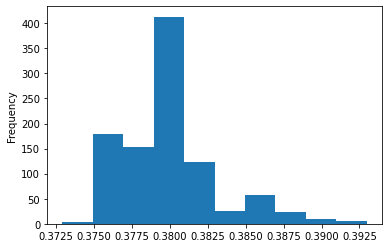

In [160]:
proba_train = cb.predict_proba(train_w2v)[:, 1]
proba_test = cb.predict_proba(test_w2v)[:, 1]

display(compute_metrics((train_label_tok, proba_train), (test_label_tok, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

## svm

In [29]:
from sklearn.svm import SVC

In [34]:
clf = SVC(probability=True)

clf.fit(train_w2v, train_label_tok)

SVC(probability=True)

,train,test
AUC,0.500769,0.518670
Accuracy,0.846000,0.793794
F1,0.090695,0.096491
Precision,0.090695,0.117021
Recall,0.090695,0.082090


|mean pred |0.083677|0.083493|


<AxesSubplot:ylabel='Frequency'>

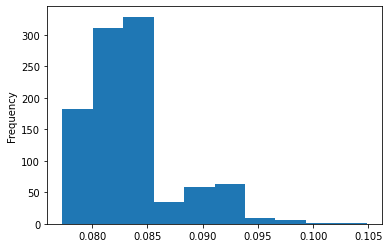

In [161]:
proba_train = clf.predict_proba(train_w2v)[:, 1]
proba_test = clf.predict_proba(test_w2v)[:, 1]

display(compute_metrics((train_label_tok, proba_train), (test_label_tok, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

# w2v 100 vector

## prep data

In [163]:
emb = W2VEmbedder(vector_size=100)
emb.get_params()

{'alpha': 0.025,
 'cbow_mean': 1,
 'epochs': 5,
 'hs': 0,
 'max_final_vocab': None,
 'min_alpha': 0.0001,
 'min_count': 5,
 'model_name': 'w2v',
 'negative': 5,
 'ns_exponent': 0.75,
 'sample': 0.001,
 'sg': 0,
 'vector_size': 100,
 'window': 5,
 'workers': 8}

In [164]:
emb.fit(train_tokens)

INFO:2022-01-07 21:58:01:gensim.models.word2vec:collecting all words and their counts
INFO:2022-01-07 21:58:01:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:2022-01-07 21:58:01:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 104799 words, keeping 21734 word types
INFO:2022-01-07 21:58:01:gensim.models.word2vec:collected 21764 word types from a corpus of 105046 raw words and 10026 sentences
INFO:2022-01-07 21:58:01:gensim.models.word2vec:Creating a fresh vocabulary
INFO:2022-01-07 21:58:01:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2518 unique words (11.56956441830546%% of original 21764, drops 19246)', 'datetime': '2022-01-07T21:58:01.060757', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO:2022-01-07 21:58:01:gensim.utils:Word2Vec lifecycle event {'msg': 'e

INFO:2022-01-07 21:58:01:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec(vocab=2518, vector_size=100, alpha=0.025)', 'datetime': '2022-01-07T21:58:01.362416', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


W2VEmbedder(vector_size=100)

In [165]:
train_w2v = emb.transform(train_tokens)
test_w2v = emb.transform(test_tokens)

## cb

In [168]:
params = {
    'eval_metric': 'AUC',
    'early_stopping_rounds': 200,
    'verbose': 10,
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_w2v, y=train_label_tok, eval_set=(test_w2v, test_label_tok))

Learning rate set to 0.056
0:	test: 0.4599733	best: 0.4599733 (0)	total: 14.6ms	remaining: 14.6s
10:	test: 0.4794625	best: 0.4966396 (6)	total: 154ms	remaining: 13.8s
20:	test: 0.4692046	best: 0.4966396 (6)	total: 294ms	remaining: 13.7s
30:	test: 0.4761151	best: 0.4966396 (6)	total: 431ms	remaining: 13.5s
40:	test: 0.4820378	best: 0.4966396 (6)	total: 571ms	remaining: 13.4s
50:	test: 0.4767018	best: 0.4966396 (6)	total: 711ms	remaining: 13.2s
60:	test: 0.4737080	best: 0.4966396 (6)	total: 846ms	remaining: 13s
70:	test: 0.4757484	best: 0.4966396 (6)	total: 986ms	remaining: 12.9s
80:	test: 0.4784919	best: 0.4966396 (6)	total: 1.16s	remaining: 13.2s
90:	test: 0.4860625	best: 0.4966396 (6)	total: 1.3s	remaining: 13s
100:	test: 0.4894013	best: 0.4966396 (6)	total: 1.45s	remaining: 12.9s
110:	test: 0.5084850	best: 0.5084850 (110)	total: 1.59s	remaining: 12.8s
120:	test: 0.5049392	best: 0.5094686 (111)	total: 1.74s	remaining: 12.6s
130:	test: 0.5115219	best: 0.5119877 (129)	total: 1.88s	remai

,train,test
AUC,0.785252,0.511988
Accuracy,0.831039,0.802803
F1,0.002356,0.075117
Precision,0.002356,0.101266
Recall,0.002356,0.059701


|mean pred |0.083908|0.085098|


<AxesSubplot:ylabel='Frequency'>

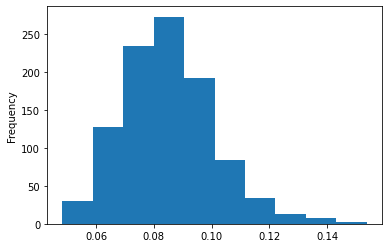

In [169]:
proba_train = cb.predict_proba(train_w2v)[:, 1]
proba_test = cb.predict_proba(test_w2v)[:, 1]

display(compute_metrics((train_label_tok, proba_train), (test_label_tok, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

## svm

In [166]:
clf = SVC(probability=True)

clf.fit(train_w2v, train_label_tok)

SVC(probability=True)

,train,test
AUC,0.512709,0.482340
Accuracy,0.842210,0.805806
F1,0.068316,0.126126
Precision,0.068316,0.159091
Recall,0.068316,0.104478


|mean pred |0.083236|0.083327|


<AxesSubplot:ylabel='Frequency'>

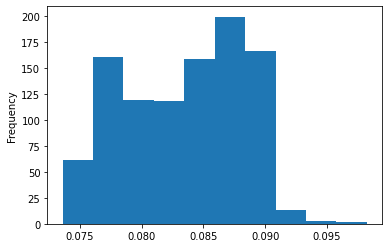

In [167]:
proba_train = clf.predict_proba(train_w2v)[:, 1]
proba_test = clf.predict_proba(test_w2v)[:, 1]

display(compute_metrics((train_label_tok, proba_train), (test_label_tok, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

# w2v 500

## prep data

In [171]:
emb = W2VEmbedder(vector_size=500)
emb.get_params()

emb.fit(train_tokens)
train_w2v = emb.transform(train_tokens)
test_w2v = emb.transform(test_tokens)

INFO:2022-01-07 22:04:38:gensim.models.word2vec:collecting all words and their counts
INFO:2022-01-07 22:04:38:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:2022-01-07 22:04:38:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 104799 words, keeping 21734 word types
INFO:2022-01-07 22:04:38:gensim.models.word2vec:collected 21764 word types from a corpus of 105046 raw words and 10026 sentences
INFO:2022-01-07 22:04:38:gensim.models.word2vec:Creating a fresh vocabulary
INFO:2022-01-07 22:04:38:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2518 unique words (11.56956441830546%% of original 21764, drops 19246)', 'datetime': '2022-01-07T22:04:38.202682', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO:2022-01-07 22:04:38:gensim.utils:Word2Vec lifecycle event {'msg': 'e

## cb

Learning rate set to 0.056
0:	test: 0.4690363	best: 0.4690363 (0)	total: 52.9ms	remaining: 52.9s
10:	test: 0.4592529	best: 0.4690363 (0)	total: 559ms	remaining: 50.2s
20:	test: 0.4671340	best: 0.4690363 (0)	total: 1.09s	remaining: 50.6s
30:	test: 0.4568545	best: 0.4690363 (0)	total: 1.61s	remaining: 50.3s
40:	test: 0.4539772	best: 0.4690363 (0)	total: 2.11s	remaining: 49.4s
50:	test: 0.4597662	best: 0.4690363 (0)	total: 2.62s	remaining: 48.8s
60:	test: 0.4593435	best: 0.4690363 (0)	total: 3.12s	remaining: 48s
70:	test: 0.4702226	best: 0.4706453 (68)	total: 3.61s	remaining: 47.2s
80:	test: 0.4680226	best: 0.4733112 (72)	total: 4.1s	remaining: 46.5s
90:	test: 0.4634717	best: 0.4733112 (72)	total: 4.58s	remaining: 45.8s
100:	test: 0.4589164	best: 0.4733112 (72)	total: 5.08s	remaining: 45.2s
110:	test: 0.4581054	best: 0.4733112 (72)	total: 5.58s	remaining: 44.7s
120:	test: 0.4568890	best: 0.4733112 (72)	total: 6.1s	remaining: 44.3s
130:	test: 0.4555949	best: 0.4733112 (72)	total: 6.63s	rem

,train,test
AUC,0.670866,0.473311
Accuracy,0.835228,0.810811
F1,0.027091,0.078049
Precision,0.027091,0.112676
Recall,0.027091,0.059701


|mean pred |0.086777|0.0878|


<AxesSubplot:ylabel='Frequency'>

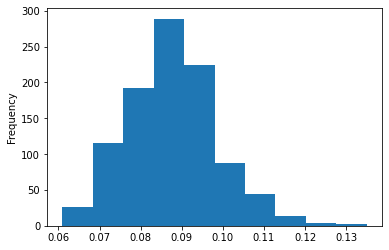

In [173]:
params = {
    'eval_metric': 'AUC',
    'early_stopping_rounds': 200,
    'verbose': 10,
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_w2v, y=train_label_tok, eval_set=(test_w2v, test_label_tok))

proba_train = cb.predict_proba(train_w2v)[:, 1]
proba_test = cb.predict_proba(test_w2v)[:, 1]

display(compute_metrics((train_label_tok, proba_train), (test_label_tok, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

## svm

,train,test
AUC,0.466008,0.516720
Accuracy,0.849192,0.806807
F1,0.109541,0.102326
Precision,0.109541,0.135802
Recall,0.109541,0.082090


|mean pred |0.084546|0.084497|


<AxesSubplot:ylabel='Frequency'>

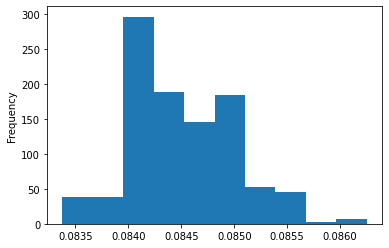

In [174]:
clf = SVC(probability=True)

clf.fit(train_w2v, train_label_tok)

proba_train = clf.predict_proba(train_w2v)[:, 1]
proba_test = clf.predict_proba(test_w2v)[:, 1]

display(compute_metrics((train_label_tok, proba_train), (test_label_tok, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

# w2v 100 skip-gram

## prep data

In [244]:
emb.get_params()

{'alpha': 0.025,
 'cbow_mean': 1,
 'epochs': 10,
 'hs': 0,
 'max_final_vocab': None,
 'min_alpha': 0.0001,
 'min_count': 5,
 'model_name': 'w2v',
 'negative': 5,
 'ns_exponent': 0.75,
 'sample': 0.001,
 'sg': 1,
 'vector_size': 250,
 'window': 5,
 'workers': 8}

In [253]:
emb = W2VEmbedder(vector_size=250, sg=1, epochs=5, max_final_vocab=5000)


emb.fit(train_tokens)
train_w2v = emb.transform(train_tokens)
test_w2v = emb.transform(test_tokens)

INFO:2022-01-07 22:37:35:gensim.models.word2vec:collecting all words and their counts
INFO:2022-01-07 22:37:35:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:2022-01-07 22:37:35:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 104799 words, keeping 21734 word types
INFO:2022-01-07 22:37:35:gensim.models.word2vec:collected 21764 word types from a corpus of 105046 raw words and 10026 sentences
INFO:2022-01-07 22:37:35:gensim.utils:Word2Vec lifecycle event {'msg': 'max_final_vocab=5000 and min_count=5 resulted in calc_min_count=3, effective_min_count=5', 'datetime': '2022-01-07T22:37:35.125881', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO:2022-01-07 22:37:35:gensim.models.word2vec:Creating a fresh vocabulary
INFO:2022-01-07 22:37:35:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min

INFO:2022-01-07 22:37:35:gensim.utils:Word2Vec lifecycle event {'msg': 'training on 525230 raw words (270542 effective words) took 0.5s, 501949 effective words/s', 'datetime': '2022-01-07T22:37:35.727480', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
INFO:2022-01-07 22:37:35:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec(vocab=2518, vector_size=250, alpha=0.025)', 'datetime': '2022-01-07T22:37:35.727480', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


## cb

0:	test: 0.5206583	best: 0.5206583 (0)	total: 52.3ms	remaining: 52.3s
10:	test: 0.5478820	best: 0.5478820 (10)	total: 827ms	remaining: 1m 14s
20:	test: 0.5511172	best: 0.5644164 (18)	total: 1.7s	remaining: 1m 19s
30:	test: 0.5448322	best: 0.5644164 (18)	total: 2.47s	remaining: 1m 17s
40:	test: 0.5378699	best: 0.5644164 (18)	total: 3.28s	remaining: 1m 16s
50:	test: 0.5342162	best: 0.5644164 (18)	total: 4.05s	remaining: 1m 15s
60:	test: 0.5404624	best: 0.5644164 (18)	total: 4.76s	remaining: 1m 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5644163575
bestIteration = 18

Shrink model to first 19 iterations.


,train,test
AUC,0.625901,0.564416
Accuracy,0.835428,0.807808
F1,0.028269,0.085714
Precision,0.028269,0.118421
Recall,0.028269,0.067164


|mean pred |0.397805|0.397815|


<AxesSubplot:ylabel='Frequency'>

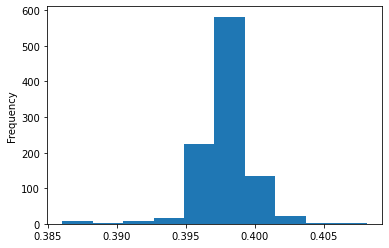

In [257]:
params = {
    'eval_metric': 'AUC',
    'early_stopping_rounds': 50,
    'verbose': 10,
    'grow_policy': 'Depthwise', #'SymmetricTree', 'Depthwise', 'Lossguide'
    'min_data_in_leaf': 10,
    'learning_rate': 0.01,
    'reg_lambda': 5
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_w2v, y=train_label_tok, eval_set=(test_w2v, test_label_tok))

proba_train = cb.predict_proba(train_w2v)[:, 1]
proba_test = cb.predict_proba(test_w2v)[:, 1]

display(compute_metrics((train_label_tok, proba_train), (test_label_tok, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()